<a href="https://colab.research.google.com/github/sujajohn26/sujajohn26.github.io/blob/main/Diamond_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
# Creating session
spark = SparkSession.builder.appName("Diamonds").getOrCreate()

In [ ]:
# Loading data
data = spark.read.csv("diamonds.csv", header=True, inferSchema=True)

In [ ]:
# Data schema
data.printSchema()

# Summary statistics
data.describe().show()

root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- price: double (nullable = true)
 |-- 'x': double (nullable = true)
 |-- 'y': double (nullable = true)
 |-- 'z': double (nullable = true)

+-------+------------------+------------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|             carat|         cut|color|clarity|             depth|             table|            price|               'x'|               'y'|               'z'|
+-------+------------------+------------+-----+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             53940|       53940|53940|  53940|             53940|             53940|            53940|            

In [ ]:
# Checking null values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----+---+-----+-------+-----+-----+-----+---+---+---+
|carat|cut|color|clarity|depth|table|price|'x'|'y'|'z'|
+-----+---+-----+-------+-----+-----+-----+---+---+---+
|    0|  0|    0|      0|    0|    0|    0|  0|  0|  0|
+-----+---+-----+-------+-----+-----+-----+---+---+---+



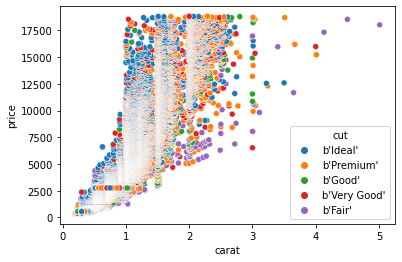

In [ ]:
# Scatter plot between carat and price
sns.scatterplot(data=data.toPandas(), x="carat", y="price", hue="cut")
plt.show()

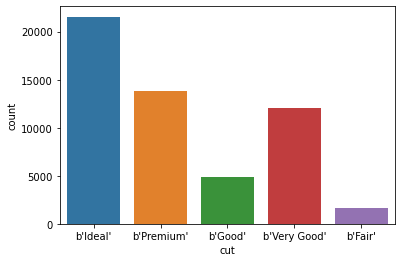

In [ ]:
# Count plot of cut
sns.countplot(data=data.toPandas(), x="cut")
plt.show()

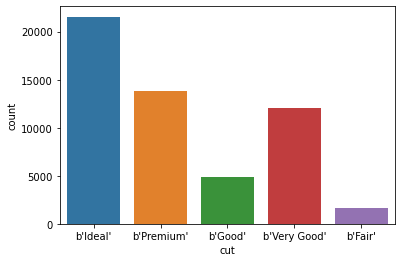

In [ ]:
# Count plot of cut
sns.countplot(data=data.toPandas(), x="cut")
plt.show()

In [ ]:

# Indexing string columns
indexer = StringIndexer(inputCols=["cut", "color", "clarity"], outputCols=["cut_index", "color_index", "clarity_index"])

# VectorAssembler
assembler = VectorAssembler(inputCols=["carat", "cut_index", "color_index", "clarity_index", "depth", "table","price", "'x'", "'y'", "'z'"], outputCol="features")

# Pipeline
pipeline = Pipeline(stages=[indexer, assembler])

# Preprocessing the data
preprocessed_data = pipeline.fit(data).transform(data)

In [ ]:
from pyspark.ml.stat import Correlation
vector_col="features"
matrix = Correlation.corr(preprocessed_data, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix[1])



[0.13496702034503097, 1.0, 0.03828291918541005, -0.09297552898322815, 0.21805500914170467, 0.4334046064815031, 0.05349066086812166, 0.12556523668382497, 0.12146186675252844, 0.14932253650526245]


In [ ]:
columns=data.columns
df = spark.createDataFrame(corrmatrix,columns)
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|               carat|                 cut|               color|             clarity|               depth|              table|               price|                 'x'|                 'y'|                 'z'|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| 0.13496702034503097| 0.18988874128642325|-0.15519218376276697| 0.02822431427904485|0.18161754651527104|  0.9215913011934445|  0.9750942267264684|  0.9517221990130027|  0.9533873805613449|
| 0.13496702034503097|                 1.0| 0.03828291918541005|-0.09297552898322815| 0.21805500914170467| 0.4334046064815031| 0.05349066086812166| 0.125565

<ipython-input-62-19bc91d92c17>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-62-19bc91d92c17>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


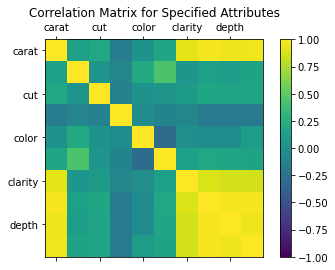

In [ ]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
# Splitting the data into train and test sets
(training_data, testing_data) = preprocessed_data.randomSplit([0.7, 0.3], seed=100)

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="cut_index", featuresCol="features")

# Training the model
dt_model = dt.fit(training_data)